In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=50)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512 )
        self.fc3 = nn.Linear(512, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.latent = None
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        self.latent = self.E(x)
        #self.data_rho = h.mean(0)
        out = self.D(self.latent)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):        
        self._rho_loss = F.l1_loss(self.latent, torch.eye(self.latent_size))                
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'50': Net(50)}
rho = 1/20
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            #print ("rho_loss=", rho_loss)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.10f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho)
               #print ("test_rho_loss=", m.rho_loss(rho))
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Losses 50: 0.920244
Train Epoch: 1 [25000/50000 (50%)]	Losses 50: 0.248345
Train Epoch: 1 [50000/50000 (100%)]	Losses 50: 0.247805


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
50: loss: 0.2425	pho_loss: 0.0000109982

Train Epoch: 2 [0/50000 (0%)]	Losses 50: 0.246199
Train Epoch: 2 [25000/50000 (50%)]	Losses 50: 0.247176
Train Epoch: 2 [50000/50000 (100%)]	Losses 50: 0.242837
Test set:
50: loss: 0.2410	pho_loss: 0.0000098319

Train Epoch: 3 [0/50000 (0%)]	Losses 50: 0.228164
Train Epoch: 3 [25000/50000 (50%)]	Losses 50: 0.231062
Train Epoch: 3 [50000/50000 (100%)]	Losses 50: 0.261953
Test set:
50: loss: 0.2400	pho_loss: 0.0000096059

Train Epoch: 4 [0/50000 (0%)]	Losses 50: 0.257176
Train Epoch: 4 [25000/50000 (50%)]	Losses 50: 0.239510
Train Epoch: 4 [50000/50000 (100%)]	Losses 50: 0.192131
Test set:
50: loss: 0.2202	pho_loss: 0.0000103851

Train Epoch: 5 [0/50000 (0%)]	Losses 50: 0.206297
Train Epoch: 5 [25000/50000 (50%)]	Losses 50: 0.208859
Train Epoch: 5 [50000/50000 (100%)]	Losses 50: 0.205380
Test set:
50: loss: 0.2172	pho_loss: 0.0000098409

Train Epoch: 6 [0/50000 (0%)]	Losses 50: 0.216014
Train Epoch: 6 [25000/50000 (50%)]	Losses 50: 0.212

Train Epoch: 40 [25000/50000 (50%)]	Losses 50: 0.058642
Train Epoch: 40 [50000/50000 (100%)]	Losses 50: 0.060841
Test set:
50: loss: 0.0630	pho_loss: 0.0000114813

Train Epoch: 41 [0/50000 (0%)]	Losses 50: 0.062154
Train Epoch: 41 [25000/50000 (50%)]	Losses 50: 0.060882
Train Epoch: 41 [50000/50000 (100%)]	Losses 50: 0.059868
Test set:
50: loss: 0.0628	pho_loss: 0.0000115618

Train Epoch: 42 [0/50000 (0%)]	Losses 50: 0.070605
Train Epoch: 42 [25000/50000 (50%)]	Losses 50: 0.062451
Train Epoch: 42 [50000/50000 (100%)]	Losses 50: 0.057034
Test set:
50: loss: 0.0611	pho_loss: 0.0000113663

Train Epoch: 43 [0/50000 (0%)]	Losses 50: 0.050000
Train Epoch: 43 [25000/50000 (50%)]	Losses 50: 0.054911
Train Epoch: 43 [50000/50000 (100%)]	Losses 50: 0.052760
Test set:
50: loss: 0.0630	pho_loss: 0.0000115033

Train Epoch: 44 [0/50000 (0%)]	Losses 50: 0.061642
Train Epoch: 44 [25000/50000 (50%)]	Losses 50: 0.054217
Train Epoch: 44 [50000/50000 (100%)]	Losses 50: 0.057513
Test set:
50: loss: 0.0601	

Train Epoch: 78 [50000/50000 (100%)]	Losses 50: 0.042481
Test set:
50: loss: 0.0434	pho_loss: 0.0000110130

Train Epoch: 79 [0/50000 (0%)]	Losses 50: 0.041792
Train Epoch: 79 [25000/50000 (50%)]	Losses 50: 0.043628
Train Epoch: 79 [50000/50000 (100%)]	Losses 50: 0.040852
Test set:
50: loss: 0.0434	pho_loss: 0.0000109564

Train Epoch: 80 [0/50000 (0%)]	Losses 50: 0.045249
Train Epoch: 80 [25000/50000 (50%)]	Losses 50: 0.037708
Train Epoch: 80 [50000/50000 (100%)]	Losses 50: 0.038403
Test set:
50: loss: 0.0431	pho_loss: 0.0000108704

Train Epoch: 81 [0/50000 (0%)]	Losses 50: 0.046754
Train Epoch: 81 [25000/50000 (50%)]	Losses 50: 0.045360
Train Epoch: 81 [50000/50000 (100%)]	Losses 50: 0.044877
Test set:
50: loss: 0.0432	pho_loss: 0.0000109033

Train Epoch: 82 [0/50000 (0%)]	Losses 50: 0.038047
Train Epoch: 82 [25000/50000 (50%)]	Losses 50: 0.044673
Train Epoch: 82 [50000/50000 (100%)]	Losses 50: 0.038089
Test set:
50: loss: 0.0425	pho_loss: 0.0000109031

Train Epoch: 83 [0/50000 (0%)]	L

Train Epoch: 116 [50000/50000 (100%)]	Losses 50: 0.035553
Test set:
50: loss: 0.0380	pho_loss: 0.0000107168

Train Epoch: 117 [0/50000 (0%)]	Losses 50: 0.039138
Train Epoch: 117 [25000/50000 (50%)]	Losses 50: 0.035115
Train Epoch: 117 [50000/50000 (100%)]	Losses 50: 0.040287
Test set:
50: loss: 0.0365	pho_loss: 0.0000107440

Train Epoch: 118 [0/50000 (0%)]	Losses 50: 0.036041
Train Epoch: 118 [25000/50000 (50%)]	Losses 50: 0.038441
Train Epoch: 118 [50000/50000 (100%)]	Losses 50: 0.033680
Test set:
50: loss: 0.0370	pho_loss: 0.0000106711

Train Epoch: 119 [0/50000 (0%)]	Losses 50: 0.029459
Train Epoch: 119 [25000/50000 (50%)]	Losses 50: 0.033385
Train Epoch: 119 [50000/50000 (100%)]	Losses 50: 0.033347
Test set:
50: loss: 0.0356	pho_loss: 0.0000106989

Train Epoch: 120 [0/50000 (0%)]	Losses 50: 0.029106
Train Epoch: 120 [25000/50000 (50%)]	Losses 50: 0.034783
Train Epoch: 120 [50000/50000 (100%)]	Losses 50: 0.035730
Test set:
50: loss: 0.0376	pho_loss: 0.0000107194

Train Epoch: 121 [0

Train Epoch: 154 [25000/50000 (50%)]	Losses 50: 0.034917
Train Epoch: 154 [50000/50000 (100%)]	Losses 50: 0.030239
Test set:
50: loss: 0.0347	pho_loss: 0.0000105968

Train Epoch: 155 [0/50000 (0%)]	Losses 50: 0.031208
Train Epoch: 155 [25000/50000 (50%)]	Losses 50: 0.030401
Train Epoch: 155 [50000/50000 (100%)]	Losses 50: 0.032562
Test set:
50: loss: 0.0334	pho_loss: 0.0000106255

Train Epoch: 156 [0/50000 (0%)]	Losses 50: 0.027272
Train Epoch: 156 [25000/50000 (50%)]	Losses 50: 0.030532
Train Epoch: 156 [50000/50000 (100%)]	Losses 50: 0.028330
Test set:
50: loss: 0.0337	pho_loss: 0.0000105541

Train Epoch: 157 [0/50000 (0%)]	Losses 50: 0.034324
Train Epoch: 157 [25000/50000 (50%)]	Losses 50: 0.027471
Train Epoch: 157 [50000/50000 (100%)]	Losses 50: 0.032926
Test set:
50: loss: 0.0336	pho_loss: 0.0000107209

Train Epoch: 158 [0/50000 (0%)]	Losses 50: 0.031605
Train Epoch: 158 [25000/50000 (50%)]	Losses 50: 0.030075
Train Epoch: 158 [50000/50000 (100%)]	Losses 50: 0.027281
Test set:
50:

Train Epoch: 192 [25000/50000 (50%)]	Losses 50: 0.024176
Train Epoch: 192 [50000/50000 (100%)]	Losses 50: 0.028997
Test set:
50: loss: 0.0328	pho_loss: 0.0000104789

Train Epoch: 193 [0/50000 (0%)]	Losses 50: 0.029833
Train Epoch: 193 [25000/50000 (50%)]	Losses 50: 0.027606
Train Epoch: 193 [50000/50000 (100%)]	Losses 50: 0.030937
Test set:
50: loss: 0.0295	pho_loss: 0.0000104858

Train Epoch: 194 [0/50000 (0%)]	Losses 50: 0.024034
Train Epoch: 194 [25000/50000 (50%)]	Losses 50: 0.028959
Train Epoch: 194 [50000/50000 (100%)]	Losses 50: 0.026898
Test set:
50: loss: 0.0298	pho_loss: 0.0000104294

Train Epoch: 195 [0/50000 (0%)]	Losses 50: 0.029349
Train Epoch: 195 [25000/50000 (50%)]	Losses 50: 0.026262
Train Epoch: 195 [50000/50000 (100%)]	Losses 50: 0.035674
Test set:
50: loss: 0.0312	pho_loss: 0.0000104463

Train Epoch: 196 [0/50000 (0%)]	Losses 50: 0.025599
Train Epoch: 196 [25000/50000 (50%)]	Losses 50: 0.029067
Train Epoch: 196 [50000/50000 (100%)]	Losses 50: 0.028406
Test set:
50:

In [9]:
torch.save(models['50'], './model_50_tanh')


/home/aleksey/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [10]:
model = torch.load('./model_50_tanh')

In [11]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
decoded = model.decode(torch.eye(50))
dec_to_plot = decoded.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print ("encoded=",encoded)
    print((abs(encoded) > 0.02).sum(1))
    encoded[abs(encoded) < 0.02] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(-1, 1).data.numpy()

encoded= tensor([[ 0.0285, -0.0073, -0.0020,  ...,  0.0059,  0.0028,  0.0008],
        [ 0.0031,  0.0046, -0.0027,  ...,  0.0350,  0.0075, -0.0021],
        [-0.0071,  0.0136, -0.0013,  ...,  0.0865,  0.0027, -0.0001],
        ...,
        [ 0.0230,  0.0022, -0.0010,  ...,  0.0213,  0.0029, -0.0006],
        [-0.0083,  0.0139, -0.0005,  ..., -0.0211,  0.0015,  0.0012],
        [ 0.0041,  0.0157, -0.0006,  ..., -0.0217,  0.0018,  0.0005]])
tensor([3, 7, 2, 3, 5, 2, 4, 6, 8, 3, 2, 5, 2, 4, 2, 7, 2, 3, 8, 3, 3, 2, 8, 5,
        3, 2, 4, 5, 3, 2, 3, 4, 8, 9, 5, 6, 3, 2, 8, 1, 3, 3, 4, 8, 6, 2, 6, 7,
        4, 6])


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Исходные данные


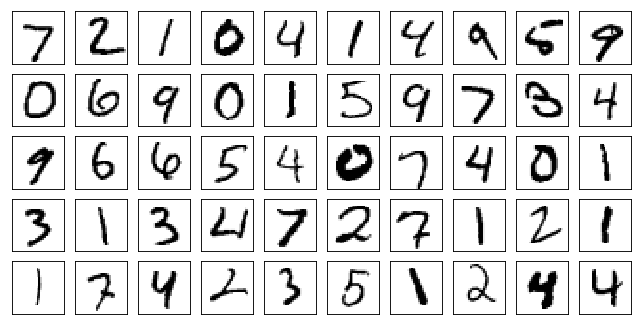

Выход декодера


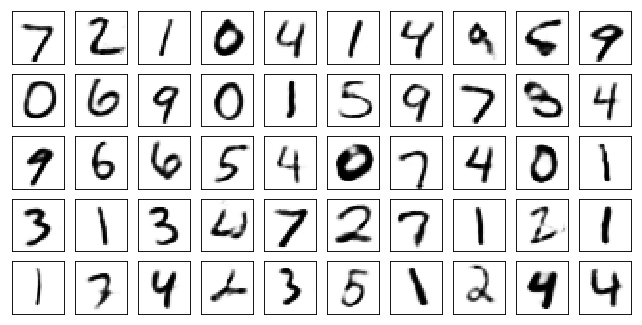

Выход декодера с отсечкой на латентном слое


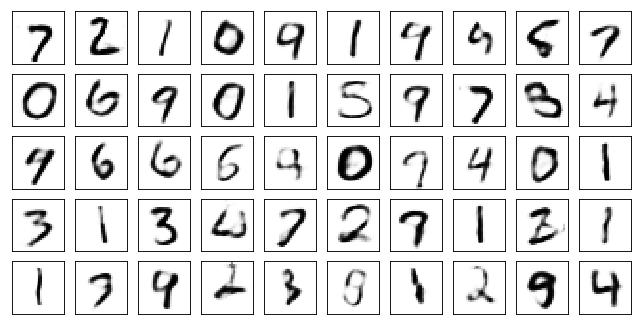

Выход декодера с единичной матрицы


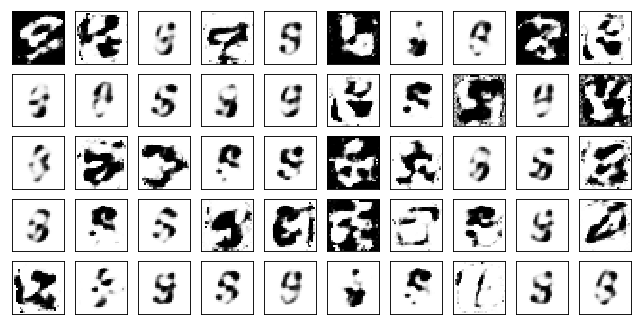

In [12]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (5, 10))

### Генерация изображений на вход энкодера

In [13]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(50)
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-3, weight_decay=0.)

    for i in range(1, 500001):  
                
        target = model.E(gen_img_par.view(-1, 28*28))
                
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 20000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 100000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
            plot_mnist(to_plot, (5, 10))
                        
    return gen_img_par    

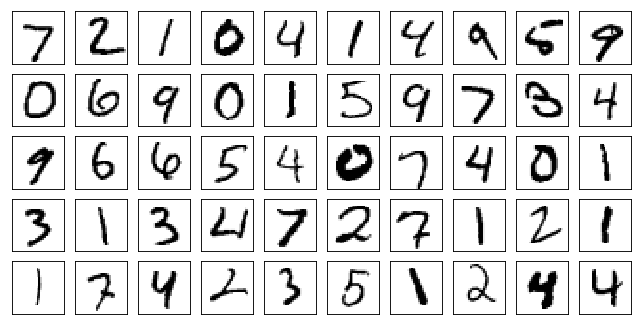

/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration 20000: loss=3.6205665310262702e-06
Iteration 40000: loss=2.124264028680045e-06
Iteration 60000: loss=1.667660626480938e-06
Iteration 80000: loss=1.4444162843574304e-06
Iteration 100000: loss=1.3043913895671722e-06


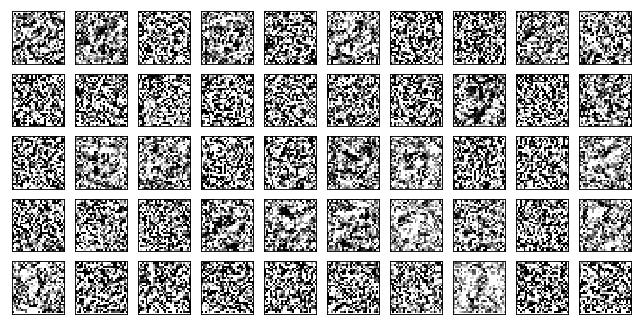

Iteration 120000: loss=1.2032641052428517e-06
Iteration 140000: loss=1.1284723768767435e-06
Iteration 160000: loss=1.070087932930619e-06
Iteration 180000: loss=1.020777062876732e-06
Iteration 200000: loss=9.80360027824645e-07


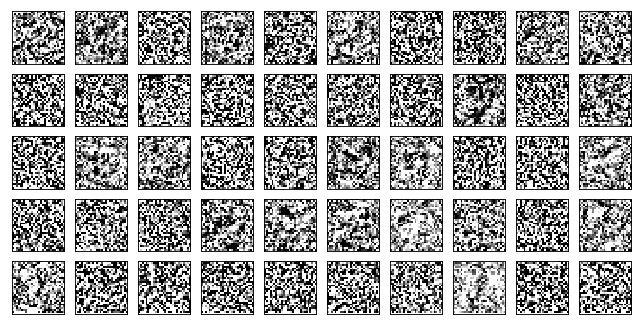

Iteration 220000: loss=9.46095155995863e-07
Iteration 240000: loss=9.190062542074884e-07
Iteration 260000: loss=8.964263429334096e-07
Iteration 280000: loss=8.763737469053012e-07
Iteration 300000: loss=8.589223057242634e-07


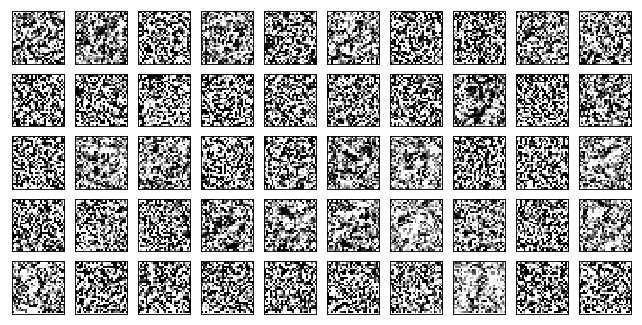

Iteration 320000: loss=8.435077916146838e-07
Iteration 340000: loss=8.296548230646295e-07
Iteration 360000: loss=8.171218723873608e-07
Iteration 380000: loss=8.055819193941716e-07
Iteration 400000: loss=7.946094342514698e-07


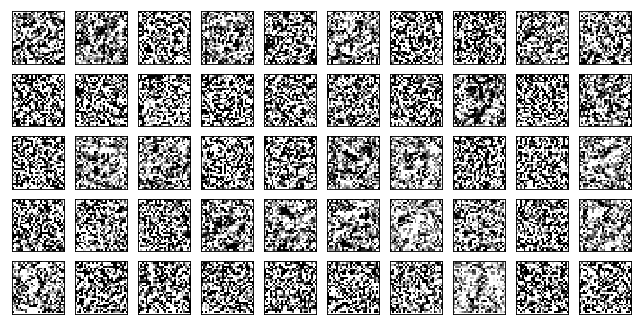

Iteration 420000: loss=7.844142828616896e-07
Iteration 440000: loss=7.751870043648523e-07
Iteration 460000: loss=7.667300110369979e-07
Iteration 480000: loss=7.588243988720933e-07
Iteration 500000: loss=7.514473736591754e-07


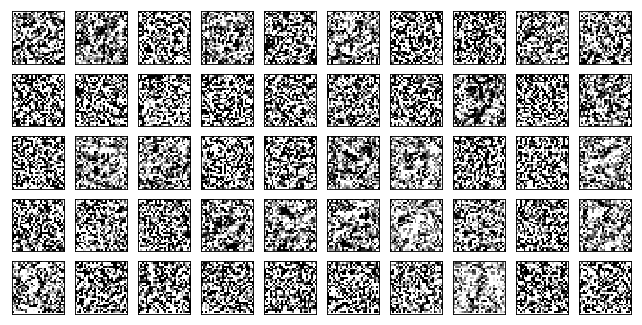

In [14]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
plot_mnist(to_plot, (5, 10))
new_image_batch = generate_image(img)

In [15]:
data, _ = next(iter(test_loader))
latent = model.E(data.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([50, 50])
tensor([[ 0.0285, -0.0073, -0.0020,  ...,  0.0059,  0.0028,  0.0008],
        [ 0.0031,  0.0046, -0.0027,  ...,  0.0350,  0.0075, -0.0021],
        [-0.0071,  0.0136, -0.0013,  ...,  0.0865,  0.0027, -0.0001],
        ...,
        [ 0.0230,  0.0022, -0.0010,  ...,  0.0213,  0.0029, -0.0006],
        [-0.0083,  0.0139, -0.0005,  ..., -0.0211,  0.0015,  0.0012],
        [ 0.0041,  0.0157, -0.0006,  ..., -0.0217,  0.0018,  0.0005]],
       grad_fn=<TanhBackward>)


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


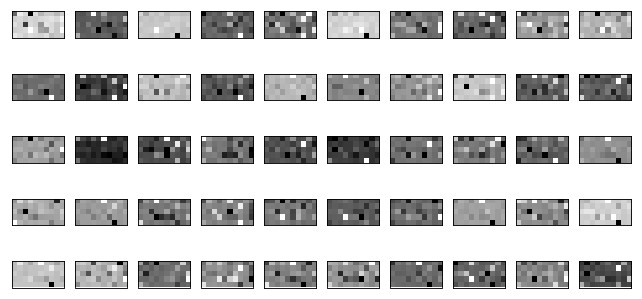

In [16]:
to_plot = latent.view(-1, 1, 5, 10).clamp(-1, 1).data.numpy()
plot_mnist(to_plot, (5, 10))